# Health data wrangling and input modelling exercises.

**In this lab you will:**

* Gain practical knowledge in pre-processing and analysing real world stochastic health system data
* Learn how to fit distribution to data
* Learn how to select a suitable distribution for your data

> **STUDENT BEWARE**: This lab can be frustrating and will test your `pandas` skills! It is designed to show you the sort of data wrangling, analysis and modelling decisions/assumptions you may need to perform in real simulation study.  But do persevere with it (answers are available as well!).  The experience should demonstrate that fitting distributions to real data is difficult and not quite as textbooks make out! By the end of the lab both your `pandas` skills and simulation input modelling skills will have improved.  >_<  

> **P.s** If you find yourself working on a simulation project in your job, it is worth remembering that simulation studies are very time consuming (i.e. problem structuring, data collection, data wrangling, input modelling, model coding and output analysis) and you have to be fairly pragmatic in your input modelling in order to get it done on time!

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Autofit imports

In [2]:
from input_modelling.fitting import auto_fit

# Exercise 1: Time dependent arrival process at an A&E

In this notebook, you will work with a hospital's Accident and Emergency (A&E) data taken from [NHS England's Synthetic A&E dataset](https://data.england.nhs.uk/dataset/a-e-synthetic-data).

Each row in the dataset represents an individual patient and information about their attendance at the A&E. 

You have the following fields:

* **Age band**: '1-17'; '18-24'; '25-44'; '45-64'; '65-84'; '84+'
* **Sex**: 1.0 or 2.0 
* **AE_Arrive_Date**: The data that patient arrived at the A&E e.g. 2015-07-02
* **AE_Arrive_HourOfDay**: Six 4 hour time bands.  '01-04'; '05-08'; '09-12'; '13-16'; '17-20'; '21-24'
* **AE_Time_Mins**: Length of stay int A&E round to the nearest 10.

The aim of exercise 1 is to investigate the **time-dependent arrival rate** to the A&E.   By the end of the exercise you need to produced a table of inter-arrival times broken down by the six **AE_Arrive_HourOfDay** bands.  

## Exercise 1.a: Read in the raw data

**Task:**
* The data for this exercise is located at the URL below.
* Use `pandas` to load it into a DataFrame.

**Questions**:
* Inspect the dataframe.  Check its
    * dimensions 
    * variable datatypes
    * if there are any missing data within the fields.

In [3]:
url = 'https://raw.githubusercontent.com/health-data-science-OR/' \
       + 'hpdm097-datasets/master/ed_input_modelling.csv'
# your code here...

In [4]:
# example solution

# read data from url
ed = pd.read_csv(url)
ed.shape

(475451, 5)

In [5]:
# AE_Arrive_HourOfDay and Sex has some missing data
# AE_Arrive_Date should be a datetime.
ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475451 entries, 0 to 475450
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Age_Band             475451 non-null  object 
 1   Sex                  475437 non-null  float64
 2   AE_Arrive_Date       475451 non-null  object 
 3   AE_Arrive_HourOfDay  475439 non-null  object 
 4   AE_Time_Mins         475451 non-null  float64
dtypes: float64(2), object(3)
memory usage: 18.1+ MB


In [6]:
# what does the missing data look like?
ed['Sex'].unique()

array([ 1.,  2., nan])

## Exercise 1.b. Preprocesses the data

**Task:**
* The field 'AE_Arrive_Date' should be a date.
* Convert this field to a datetime.
* Drop the age band 1-17 (children) as they use the paedatric A&E.

**Hints:**
* There is a built in `pandas` function to help.

**Questions**:
* What are the maximum and minimum dates int the dataset?
* How many days worth of data are there in the dataset?

In [7]:
# your code here...

In [8]:
# example solution
# date time
ed['AE_Arrive_Date'] = pd.to_datetime(ed['AE_Arrive_Date'])

# drop the kids
ed = ed.loc[ed['Age_Band'] != '1-17']

In [9]:
ed.sort_values(['AE_Arrive_Date', 'AE_Arrive_HourOfDay']).head()

,Age_Band,Sex,AE_Arrive_Date,AE_Arrive_HourOfDay,AE_Time_Mins
8184,25-44,2.0,2014-03-23,01-04,49.87
88332,85+,2.0,2014-03-23,01-04,129.80
138542,45-64,2.0,2014-03-23,01-04,158.99
146227,18-24,2.0,2014-03-23,01-04,230.08
198779,25-44,1.0,2014-03-23,01-04,367.08


In [10]:
ed.AE_Arrive_Date.max()

Timestamp('2018-03-22 00:00:00')

In [11]:
ed.AE_Arrive_Date.min()

Timestamp('2014-03-23 00:00:00')

In [12]:
# calculate the number of days
days = (ed.AE_Arrive_Date.max() - ed.AE_Arrive_Date.min()).days
days

1460

# Exercise 1.c Analyse the data for patterns

Before you produce the arrival rate you should explore the dataset for a potential trend and systemic breaks (where there is a big change in demand).

**Task**:
* Wrangle the dataset into a time series that reports the number of attendances per day.
* Plot the time series.

**Questions**
* Is there a trend in the data?
* Do your findings alter your plans for what data to include when modelling arrival rates to the A&E
* If you exclude any data how much remains?

**Hints:**
* It is possible to do this with one line of `pandas`.  If you are unsure investigate pandas options for grouping data.

In [13]:
# your code here ...

In [14]:
# example answer
select = ['AE_Arrive_Date', 'Age_Band']
ts_day = ed[select].groupby(by=['AE_Arrive_Date']).count()
ts_day.index.freq='D'

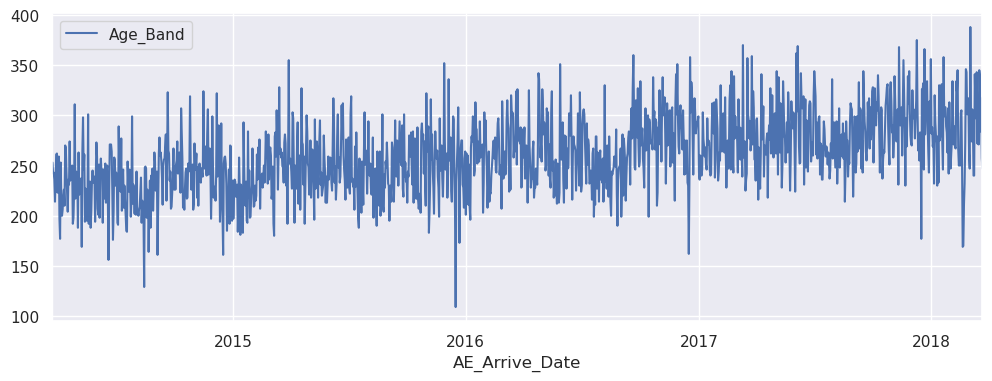

In [15]:
# definitely a trend.  
# arrivals pre=2017 excluded.
_ = ts_day.plot(figsize=(12,4))

In [16]:
# exclude pre-2017 data for arrival analysis...
ed_2017 = ed.loc[ed['AE_Arrive_Date'].dt.year >= 2017]

# update days in the dataset to be 2017+
days_2017 = (ed_2017.AE_Arrive_Date.max() - ed_2017.AE_Arrive_Date.min()).days

print(ed_2017.shape)
print(days_2017)


(126340, 5)
445


## Exercise 1.d: General arrival rates by arrival time band.

**Task:**
* Ignoring any day of week or monthly effect, calculate the mean number of arrivals per time band.
* Calculate the inter-arrival rate (IAT) for each of the 4 hour time bands.
* Plot the mean arrival rate by time of day.

**Hints:**
* This problem can again by solved by using `pandas` grouping methods.  
* The first thing you need to do is calculate the **total** number of arrivals by time band.
* To calculate the average you also need to know how many **days** there are in your dataset.
* Remember that each time band represents a 4 hour period.  IAT = Total time (in mins) / Mean No. Arrivals.


In [17]:
# example answer
select = ['AE_Arrive_HourOfDay', 'Age_Band']
arrival_pivot = ed_2017[select].groupby(by=['AE_Arrive_HourOfDay']).count()

arrival_pivot.columns = ['Arrivals']
arrival_pivot['mean_daily_arrivals'] = arrival_pivot['Arrivals'] / days_2017
arrival_pivot

,Arrivals,mean_daily_arrivals
AE_Arrive_HourOfDay,,
01-04,8628,19.388764
05-08,10873,24.433708
09-12,37673,84.658427
13-16,32302,72.588764
17-20,25816,58.013483
21-24,11044,24.817978


In [18]:
arrival_pivot['IAT'] = (60 * 4) / arrival_pivot['mean_daily_arrivals']
arrival_pivot

,Arrivals,mean_daily_arrivals,IAT
AE_Arrive_HourOfDay,,,
01-04,8628,19.388764,12.378303
05-08,10873,24.433708,9.822496
09-12,37673,84.658427,2.834922
13-16,32302,72.588764,3.306297
17-20,25816,58.013483,4.136969
21-24,11044,24.817978,9.670409


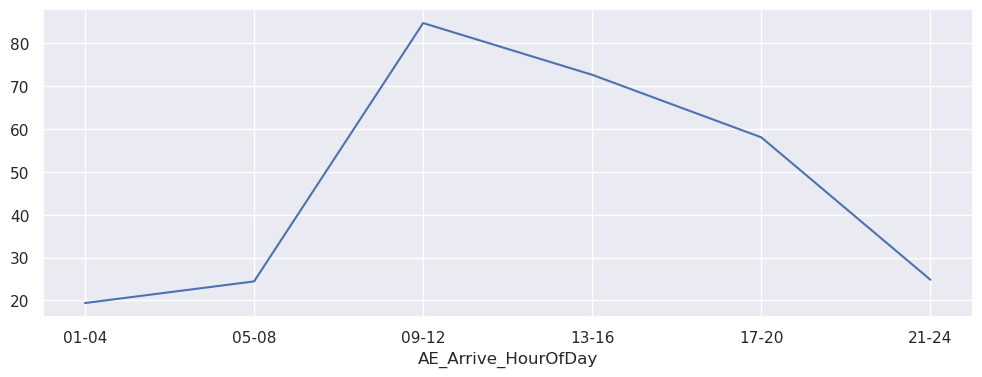

In [19]:
# plot the arrival profile
_ = arrival_pivot['mean_daily_arrivals'].plot(figsize=(12,4))

# Exercise 2: Choosing a distribution to model length of stay

The next step in your A&E simulation input modelling is to select a distribution to represent the total time a patient spends in the department.  It is possible the distribution - or at least the parameters - will vary by different subgroups in the population.  For, example the over 65's may have a different distribution from the under 65s.

## Exercise 2.a

**Task**
* Plot a histogram of the time spent in A&E, ignoring any subgroups of the population.
* Use `auto_fit` to help you select a distribution.  Set the parameter `pp=True`

**Questions**
* Has `auto_fit` been useful?  If so which elements of it?
* What do  you conclude from the p-p plots?

**Hints**
* For this exercise it is okay to use the full date range of the ED data, but make sure you exclude the under 18s.

In [20]:
# your code here...

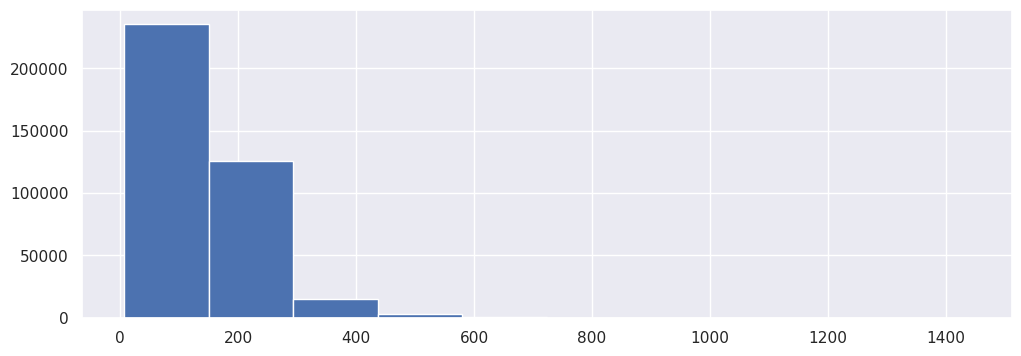

In [21]:
# example solution
ax = ed['AE_Time_Mins'].hist(figsize=(12,4))


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
6  weibull_min  9.665390e+03      0.0
0         beta  1.334245e+04      0.0
2        gamma  1.509340e+04      0.0
5     pearson3  1.509627e+04      0.0
3      lognorm  3.544649e+04      0.0
4         norm  5.482776e+05      0.0
1        expon  6.391024e+05      0.0
7  weibull_max  3.322957e+06      0.0


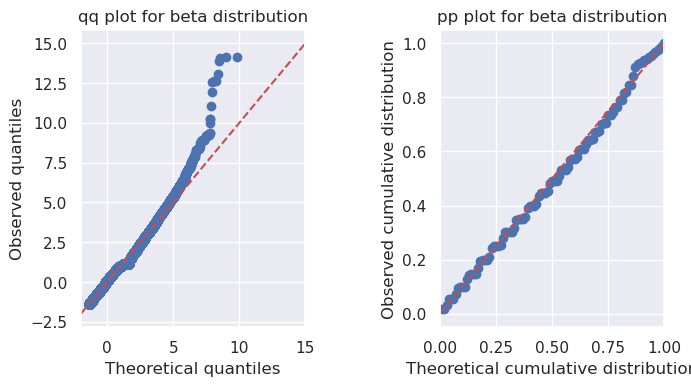

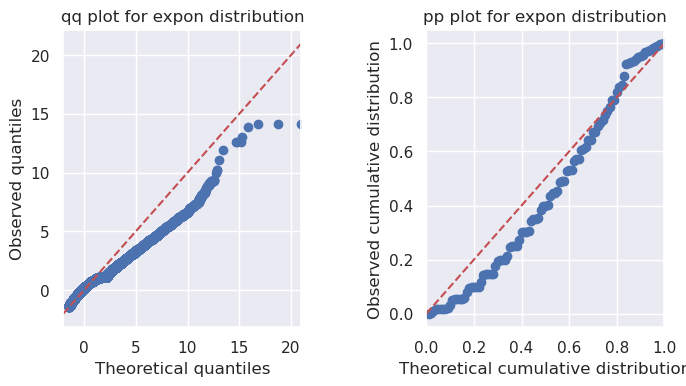

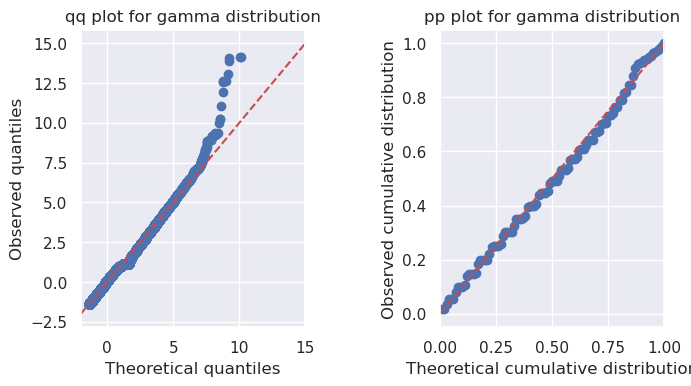

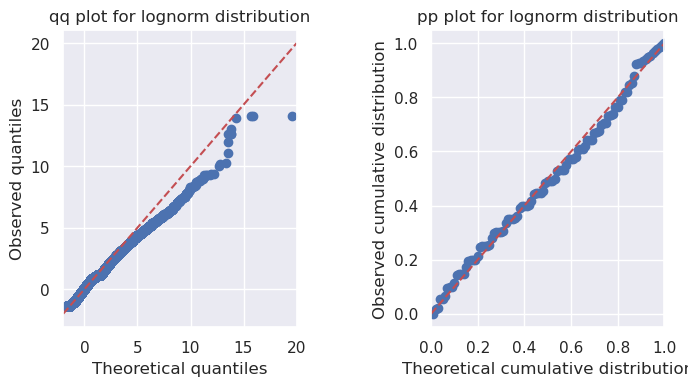

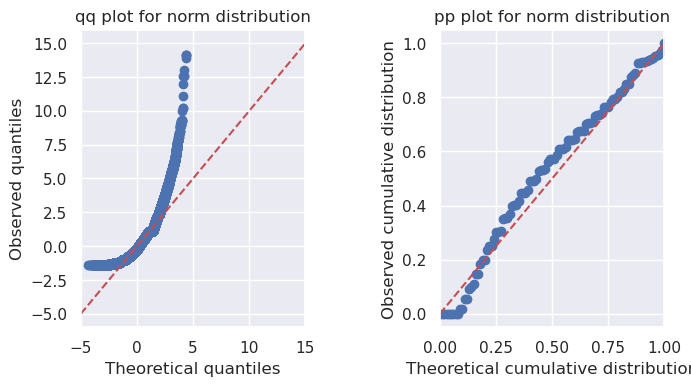

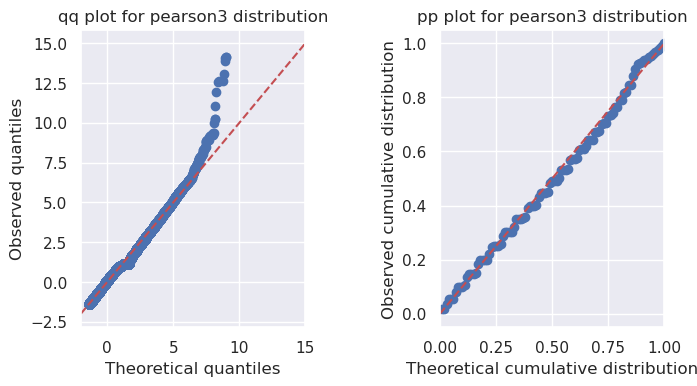

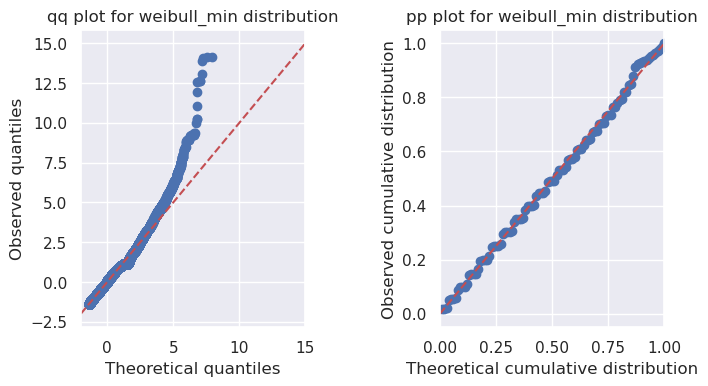

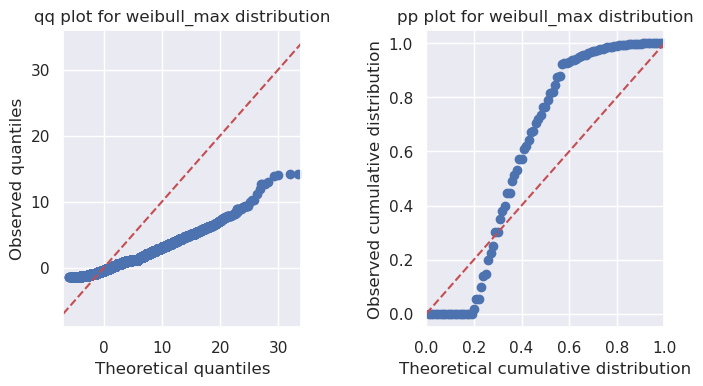

In [22]:
## this will take 30 or so seconds to run as it is a lot of data.
auto_fit(ed['AE_Time_Mins'], pp=True, hist=False)

## Exercise 2.b: LoS by age banding

**Task:**
* Investigate if different subgroups have different length of stay distributions.
* Your analysis should check if there is a difference in the over and under 65s. 

**Questions**:
* What distributions would you select for these subgroups?

In [23]:
# example solution

# over 65s = 65-84 or 85+
over65s = ed.loc[(ed['Age_Band'] == '65-84') | (ed['Age_Band'] == '85+')]

# under 65s is the inverse
under65s = ed.loc[~((ed['Age_Band'] == '65-84') | (ed['Age_Band'] == '85+'))]

print(over65s.shape)
print(under65s.shape)

# check
print(under65s.Age_Band.unique())

# check
print(over65s.Age_Band.unique())

(131240, 5)
(249198, 5)
['45-64' '25-44' '18-24']
['65-84' '85+']


In [24]:
over65s['AE_Time_Mins'].describe()

count    131240.000000
mean        151.970918
std          99.874075
min           6.170000
25%          78.130000
50%         139.200000
75%         210.790000
max        1439.880000
Name: AE_Time_Mins, dtype: float64

In [25]:
# it looks like there is quite a big differece in LoS.
under65s['AE_Time_Mins'].describe()

count    249198.000000
mean        126.488266
std          86.962579
min           6.180000
25%          60.200000
50%         109.700000
75%         179.220000
max        1440.060000
Name: AE_Time_Mins, dtype: float64

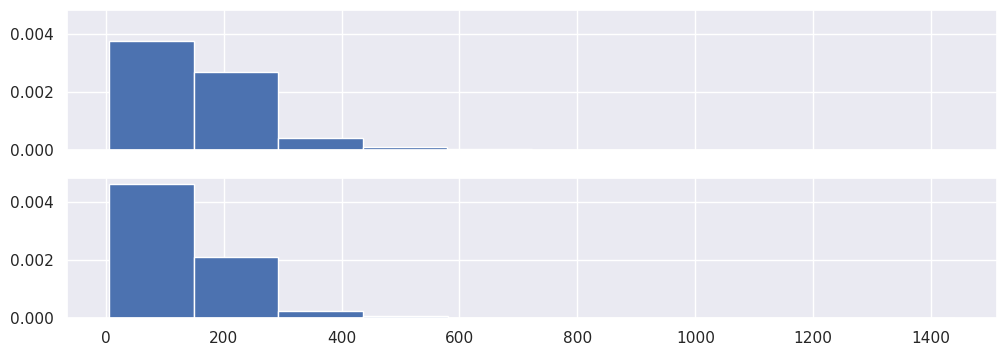

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(12,4), sharex=True, sharey=True)
ax[0].hist(over65s['AE_Time_Mins'], density=True)
ax[1].hist(under65s['AE_Time_Mins'],  density=True);


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution     chi_square  p_value
6  weibull_min    4848.499128      0.0
0         beta    6694.679403      0.0
5     pearson3    8403.618049      0.0
2        gamma    8403.929377      0.0
3      lognorm   15971.356716      0.0
7  weibull_max   29566.116869      0.0
4         norm  153912.565510      0.0
1        expon  247471.369834      0.0


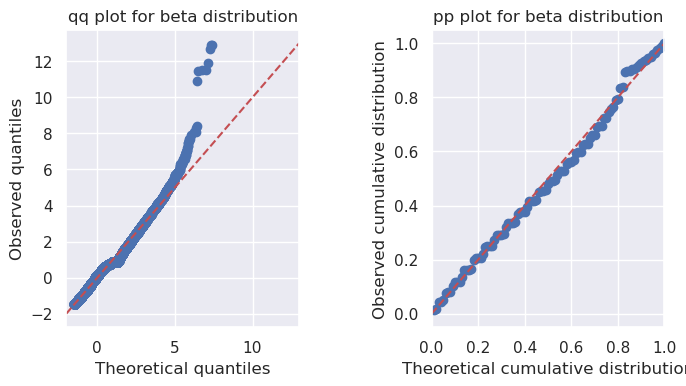

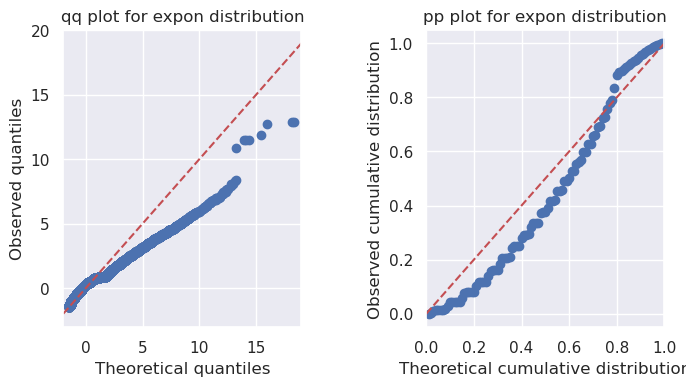

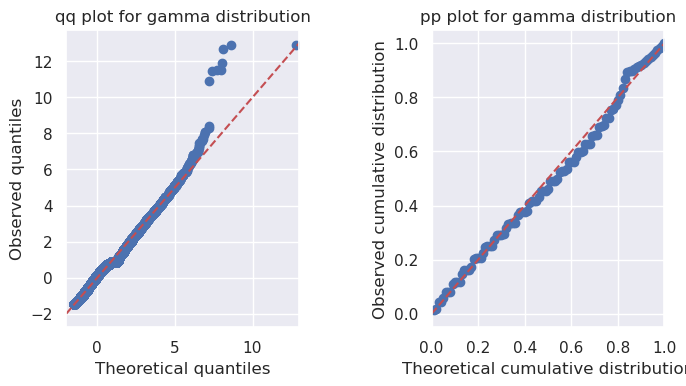

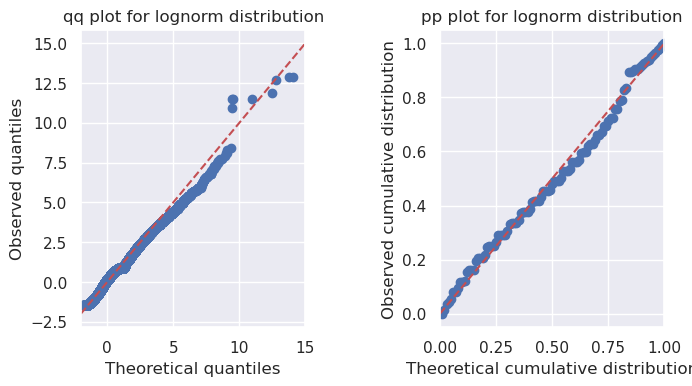

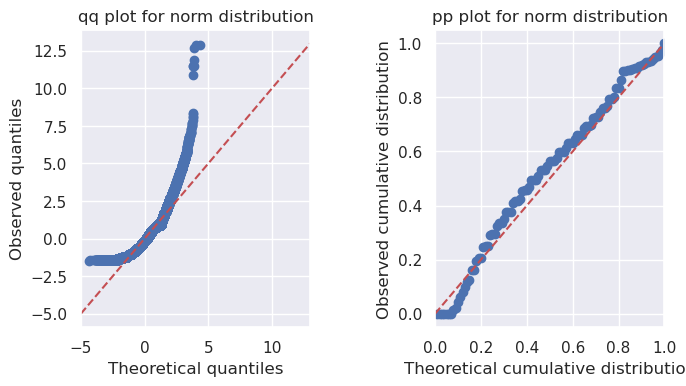

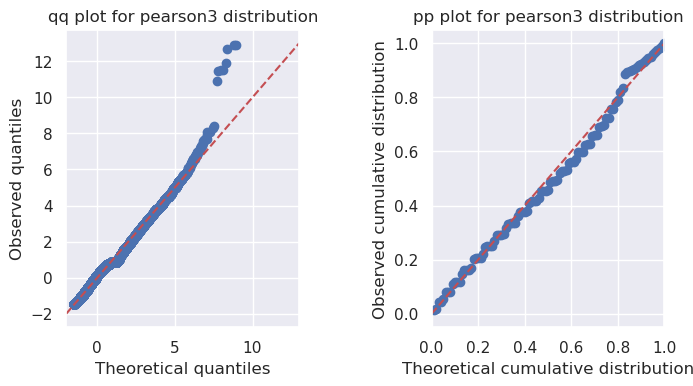

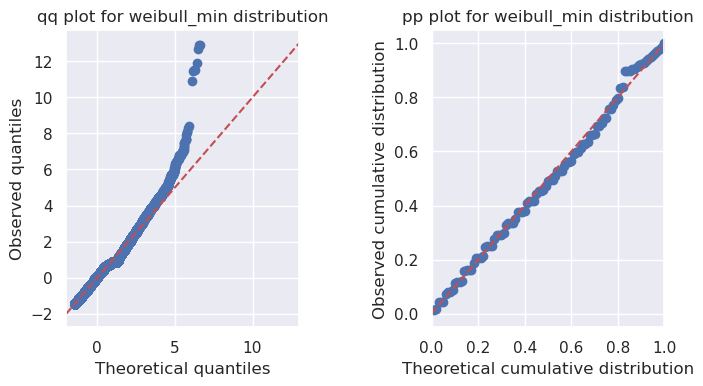

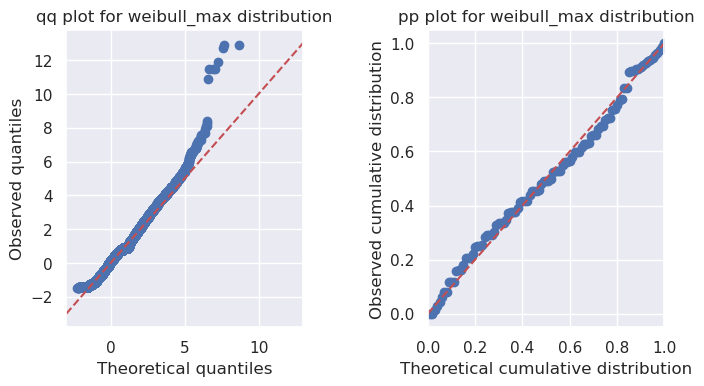

In [27]:
auto_fit(over65s['AE_Time_Mins'], pp=True)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
6  weibull_min  5.892363e+03      0.0
0         beta  8.417744e+03      0.0
5     pearson3  9.726114e+03      0.0
2        gamma  9.727822e+03      0.0
3      lognorm  2.176968e+04      0.0
1        expon  3.674311e+05      0.0
4         norm  3.755025e+05      0.0
7  weibull_max  5.795347e+06      0.0


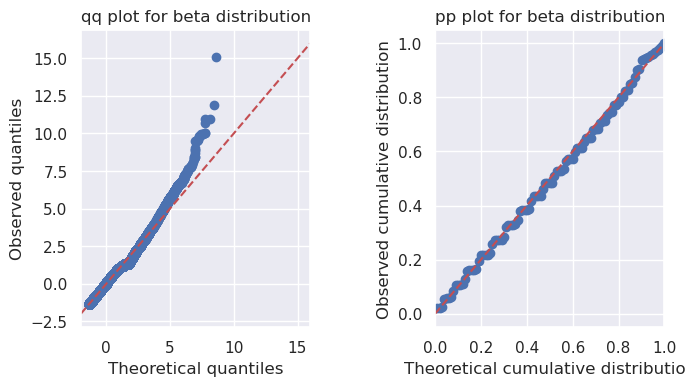

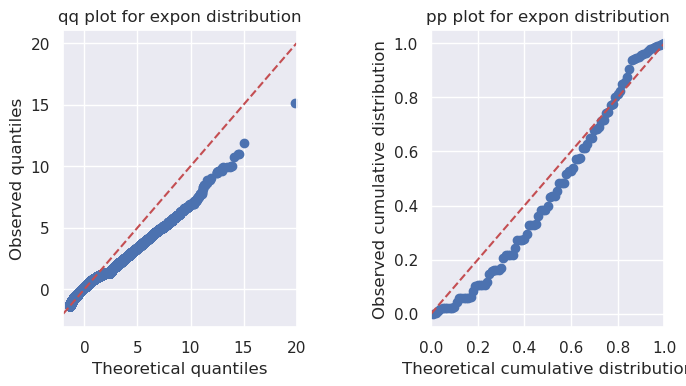

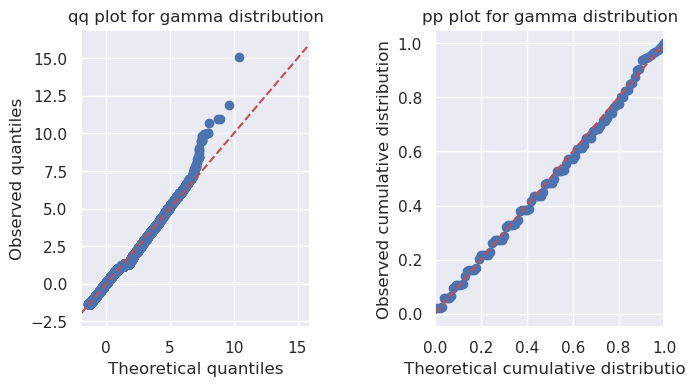

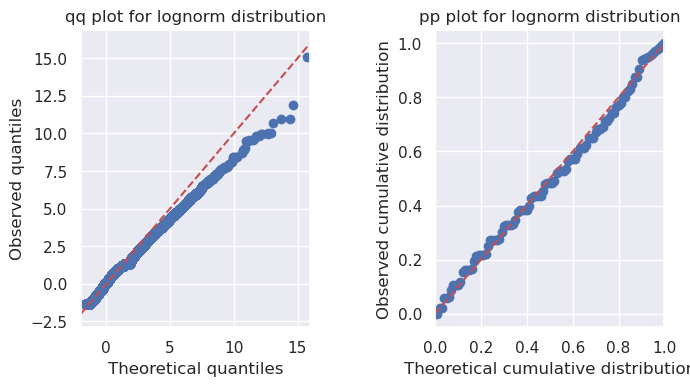

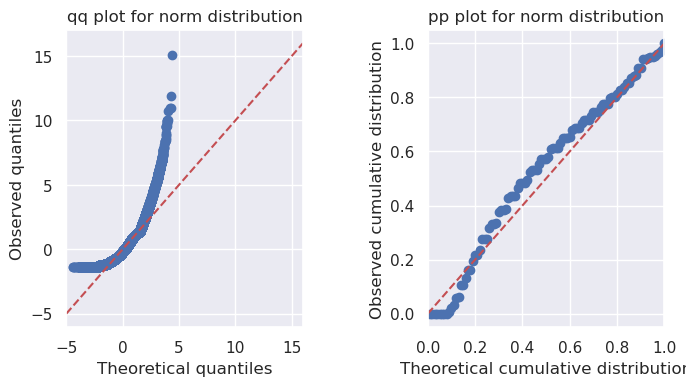

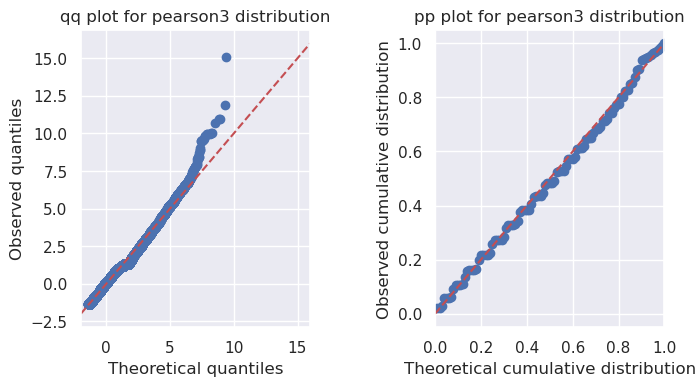

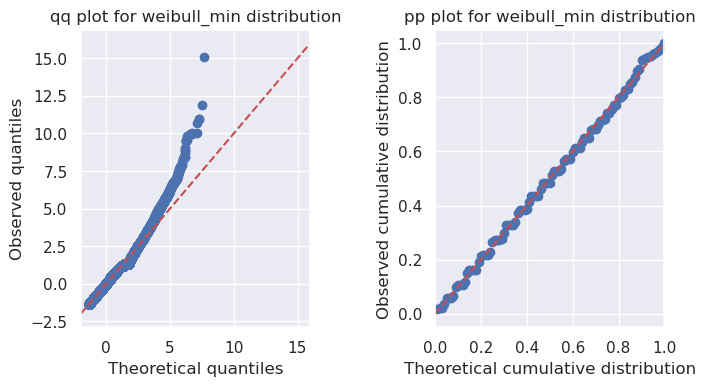

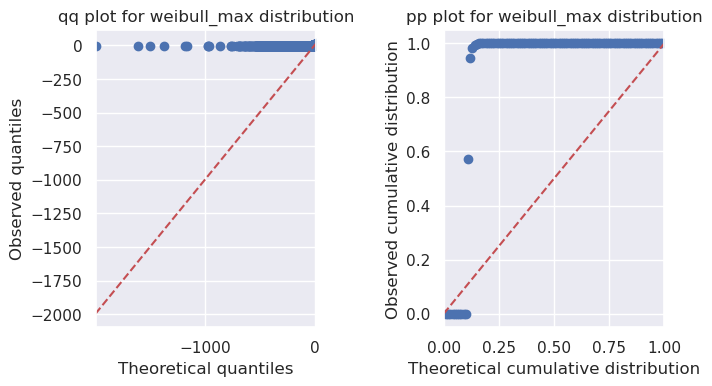

In [28]:
auto_fit(under65s['AE_Time_Mins'], pp=True)

# End.